In [4]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.ticker 
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import time as t
import os, sys
from tqdm import tnrange

from astropy.io import fits
from astropy.stats import sigma_clip

from photutils import aperture_photometry
from photutils import CircularAperture
from photutils.datasets import make_4gaussians_image

import glob
import csv
import operator
import warnings

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import Photometry_Aperture as reduc

#from photutils.morphology import centroid_1dg,centroid_2dg
#np.set_printoptions(threshold=np.nan)

# Ignore warning and starts timing
warnings.filterwarnings('ignore')

In [8]:
# Define paths
planet     = 'XO-3b'

# Data year
year = '2013'

# path to Spitzer data
# datapath   = '/volumes/Seagate Expansion Drive/Research/Spitzer_Data/XO-3b/Phase_'+ year +'_ch1'  
datapath = '/Users/ldang/Downloads/kelt-20b/'

# path where the results will be saved
#folderpre  = '../../../../../../volumes/Seagate Expansion Drive/Research/XO-3b/ch1/Analysis_'+ year +'/'  
#folder     = folderpre + '3um_PLD_3x3'

folder = '/Users/ldang/Downloads/kelt-20b/results'

# Describe spitzer observations
AOR_snip   = 'r687'                                # first characters of AOR directories
channel    = 'ch2'                                 # spitzer channel used
subarray   = True

# Details about the photometry
Ptype      = 'Aperture'                                 # Aperture, PSF_fit, or PLD

# Details about Aperture photometry
shape      = 'Circular'                            # shape of the aperture 
radius     = 3.75                                  # if 'circular' define radius
a, b       = 1.5, 1.5                              # if elliptical define semi-major and semi-minor axis
w_r, h_r   = 1.5, 1.5                              # if rectangular, define width and height
method     = 'center'                              # 'exact', 'subpixel' or 'center'
moving     = False                                 # aperture centered on centroid?
cx, cy     = 15, 15                                # center of fixed aperture
'''need to implement the moving vs not moving aperture'''

# Details about PLD photometry
boxsize    = 3
cx, cy     = 15, 15

# Image modification?
oversamp   = False                                 # do you want to oversample the image
companion  = False                                 # Is there a companion?
'''add companion to this'''

# saving and plotting
bin_data   = True
bin_size   = 64
plot       = True
save       = True
plot_name  = 'Lightcurve.pdf'
save_full  = '/ch1_datacube_full_AORs'+ AOR_snip[1:] +'.dat'
save_bin   = '/ch1_datacube_binned_AORs' + AOR_snip[1:] +'.dat'

In [9]:
# create folder
folder     = reduc.create_folder(folder)
savepath   = folder

# get list of filenames and nb of files
fnames     = reduc.get_fnames(datapath, AOR_snip, channel)

# if channel =='ch1':
#     # get correction stack
#     corr1path = datapath + '/correction_stacks/Correction_SPITZER_I1_48626432_0000_2_C10872766_sdark.fits'
#     corr2path = datapath + '/correction_stacks/Correction_SPITZER_I1_48620032_0000_2_C10872743_sdark.fits'
#     corr1_hdu = fits.open(corr1path)
#     corr2_hdu = fits.open(corr2path)
#     corr1     = corr1_hdu[0].data
#     corr2     = corr2_hdu[0].data
#     listcorr1 = ['46482688', 'r46482944']

# elif channel =='ch2':
#     # get correction stack
#     corr1path = 'Correction_stacks/Correction_SPITZER_I2_48659712_0000_2_C10872880_sdark.fits'
#     corr2path = 'Correction_stacks/Correction_SPITZER_I2_48648960_0000_2_C10872839_sdark.fits'
#     corr1_hdu = fits.open(corr1path)
#     corr2_hdu = fits.open(corr2path)
#     corr1     = corr1_hdu[0].data
#     corr2     = corr2_hdu[0].data
#     listcorr1 = ['46484224', 'r46484992', 'r46485504', 'r46486016', 'r46486528', 'r46486784']

In [10]:
# variables declaration 
percent       = 0                   # to show progress while running the code
tossed        = 0                   # Keep tracks of number of frame discarded 
badframetable = []                  # list of filenames of the discarded frames
time          = []                  # time array
bg_flux       = []                  # background flux 
bg_err        = []                  # background flux error 
xo            = []                  # centroid value along the x-axis
yo            = []                  # centroid value along the y-axis
xw            = []                  # PSF width along the x-axis
yw            = []                  # PSF width along the y-axis

if Ptype == 'Aperture':
    aperture_sum  = []              # flux obtained from aperture photometry
    aperture_sum_err = []           # error on flux obtained from aperture photometry
    
elif Ptype == 'PLD':
    P             = np.empty(shape = (0,boxsize**2))

In [13]:
#if (subarray == True):
if Ptype == 'Aperture':

    #for i in tnrange(30):
    for i in tnrange(len(fnames)):

        # open fits file
        hdu_list = fits.open(fnames[i])
        image_data0 = hdu_list[0].data
        #if any(x in fnames[i] for x in listcorr1):
        #    image_data0 = hdu_list[0].data + corr1
        #else:
        #    image_data0 = hdu_list[0].data + corr2
        h, w, l = image_data0.shape
        
        # get time
        time = reduc.get_time(hdu_list, time)
        
        # convert MJy/str to electron count
        convfact = hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
        image_data1 = convfact*image_data0
        
        # sigma clip
        fname = fnames[i]
        image_data2, tossed, badframetable = reduc.sigma_clipping(image_data1, i ,fname[fname.find('ch2/bcd/')+8:], 
                                                                  tossed=tossed)#, **kwargs)
        # bg subtract
        image_data3, bg_flux, bg_err = reduc.bgsubtract(image_data2, bg_flux, bg_err)
        
        # oversampling
        if (oversamp == True):
            image_data3 = np.ma.masked_invalid(oversampling(image_data3))
            if (saveover == True):
                savename = fnames[i]
                # THIS CHANGES FROM ONE SET OF DATA TO ANOTHER!!!
                new_name = savepath + '/Oversampled/' + savename[57:86]
                image_data3.dump(new_name)
        
        # Aperture Photometry
        if (oversamp == True):
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw, scale = 2)
            # get centroids & PSF width for companion
            #xo2, yo2, xw2, yw2 = centroid_FWM(image_data3, xo2, yo2, xw2, yw2, bounds = (12, 15, 11, 14))
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            if moving == False:
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                    aperture_sum, aperture_sum_err, cx = 2*15, 
                                                                    cy = 2*15, r = 2*2.5, a = 2*5, b = 2*5, 
                                                                    w_r = 2*5, h_r = 2*5)#, **kwargs)
            else:
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                    aperture_sum, aperture_sum_err, cx = 2*xo[:-64], 
                                                                    cy = 2*yo[:-64], r = 2*2.5, a = 2*5, b = 2*5, 
                                                                    w_r = 2*5, h_r = 2*5)#, **kwargs)
        else:
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw)
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            if moving == False:
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], 
                                                                    ecnt2Mjy, aperture_sum, 
                                                                    aperture_sum_err, method=method, 
                                                                    r=radius)#, **kwargs)
            else:
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], 
                                                                    ecnt2Mjy, aperture_sum, aperture_sum_err, cx = xo[:-64], 
                                                                    cy = yo[:-46], method=method, 
                                                                    r=radius)#, **kwargs)
        #print('Status:', i, 'out of', len(fnames))


HBox(children=(IntProgress(value=0, max=5901), HTML(value='')))

In [14]:
#if (subarray == True):
#elif (subarray == False):
#    print('Sorry this part is undercontruction!')

if Ptype == 'PLD':

    #for i in tnrange(30):
    for i in tnrange(len(fnames)):

        # open fits file
        hdu_list = fits.open(fnames[i])
        if any(x in fnames[i] for x in listcorr1):
            image_data0 = hdu_list[0].data + corr1
        else:
            image_data0 = hdu_list[0].data + corr2
        h, w, l = image_data0.shape
        
        # get time
        time = reduc.get_time(hdu_list, time)
        
        # convert MJy/str to electron count
        convfact = hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
        image_data1 = convfact*image_data0
        
        # sigma clip
        fname = fnames[i]
        image_data2, tossed, badframetable = reduc.sigma_clipping(image_data1, i ,fname[fname.find('ch2/bcd/')+8:], 
                                                                  tossed=tossed)#, **kwargs)
        # bg subtract
        image_data3, bg_flux, bg_err = reduc.bgsubtract(image_data2, bg_flux, bg_err)
        
        # get PSF metric
        xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw)
        
        # get pixel values
        P = reduc.get_pixel_values(image_data0, P, nbx = boxsize, nby = boxsize)
        
    # reconvert to MJy/str
    ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact)
    P = ecnt2Mjy*P
        
                

In [15]:
if (bin_data == True):
    binned_xo, binned_xo_std     = reduc.binning_data(np.asarray(xo), bin_size)
    binned_yo, binned_yo_std     = reduc.binning_data(np.asarray(yo), bin_size)
    binned_xw, binned_xw_std     = reduc.binning_data(np.asarray(xw), bin_size)
    binned_yw, binned_yw_std     = reduc.binning_data(np.asarray(yw), bin_size)
    binned_bg, binned_bg_std     = reduc.binning_data(np.asarray(bg_flux), bin_size)
    binned_bg_err, binned_bg_err_std = reduc.binning_data(np.asarray(bg_err), bin_size)
    
    if Ptype == 'Aperture':
        binned_flux, binned_flux_std = reduc.binning_data(np.asarray(aperture_sum), bin_size)
        binned_time, binned_time_std = reduc.binning_data(np.asarray(time), bin_size)
    if Ptype == 'PLD':
        binned_P, binned_P_std       = reduc.binning_data2D(P, bin_size)
        binned_time, binned_time_std = reduc.binning_data(np.asarray(time), bin_size)


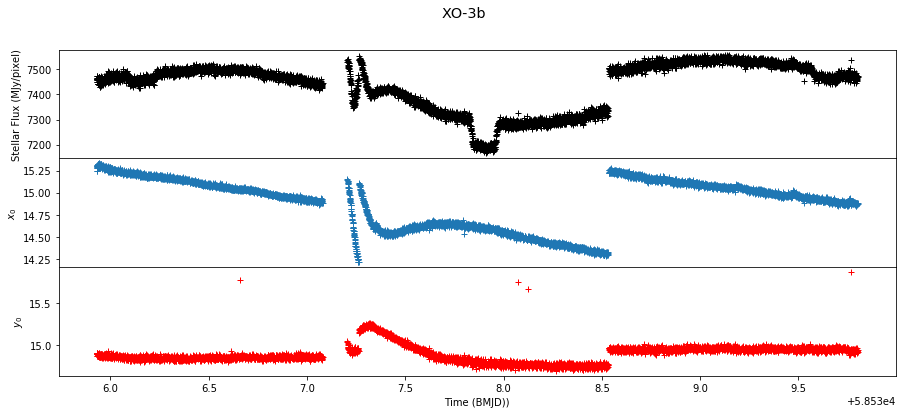

In [16]:
if (plot == True):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,6))
    fig.suptitle(planet, fontsize="x-large")
    if Ptype == 'Aperture':
        axes[0].plot(binned_time, binned_flux,'k+')
    if Ptype == 'PLD':
        axes[0].plot(binned_time, np.sum(binned_P, axis = 1), '+')
    axes[0].set_ylabel("Stellar Flux (MJy/pixel)")

    axes[1].plot(binned_time, binned_xo, '+')
    axes[1].set_ylabel("$x_0$")

    axes[2].plot(binned_time, binned_yo, 'r+')
    axes[2].set_xlabel("Time (BMJD))")
    axes[2].set_ylabel("$y_0$")
    fig.subplots_adjust(hspace=0)
    if (save == True):
        pathplot = savepath + '/' + plot_name
        fig.savefig(pathplot)

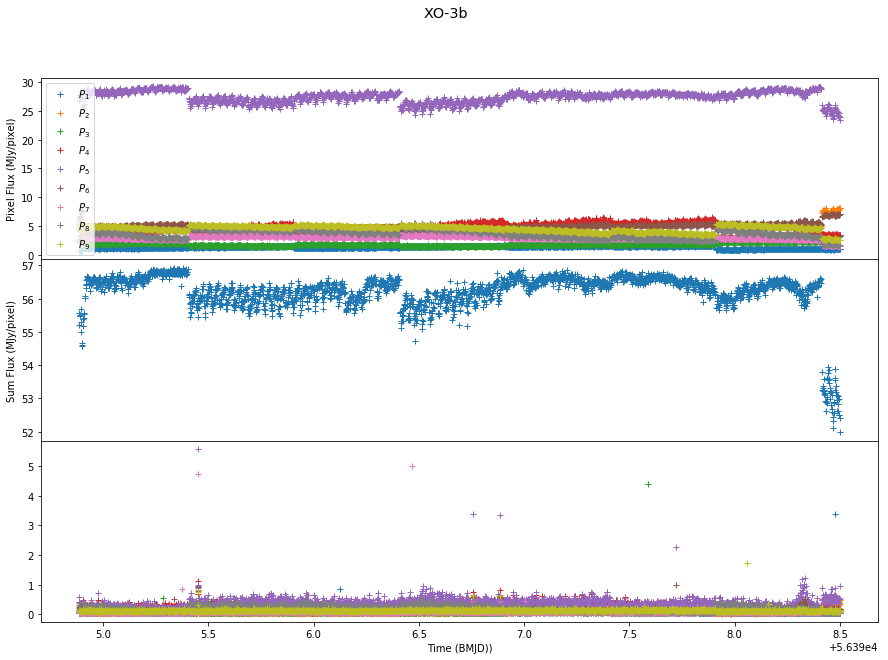

In [9]:
if Ptype == 'PLD':
    if plot == True:

        fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex = True, figsize=(15,10))
        fig.suptitle(planet, fontsize="x-large")
        
        for i in range(boxsize**2):
            label = '$P_' + str(i+1) + '$'
            axes[0].plot(binned_time, binned_P[:,i], '+', label = label)
        axes[0].set_ylabel("Pixel Flux (MJy/pixel)")
        #axes[0].set_ylim(0,0.01)
        axes[0].legend()
        
        axes[1].set_ylabel('Sum Flux (MJy/pixel)')
        axes[1].plot(binned_time, np.sum(binned_P, axis = 1), '+')
        
        for i in range(boxsize**2):
            label = '$Pstd_' + str(i+1) + '$'
            axes[2].plot(binned_time, binned_P_std[:,i], '+', label = '$Pstd_1$')
        axes[2].set_xlabel("Time (BMJD))")
        fig.subplots_adjust(hspace=0)

        if (save == True):
            pathplot = savepath + '/' + 'PLD_'+ plot_name 
            fig.savefig(pathplot)
            plt.show()

In [10]:
if Ptype == 'Aperture':
    if (save == True):
        # Full data
        FULL_data = np.c_[aperture_sum, aperture_sum_err, time, xo, yo, xw, yw, bg_flux, bg_err]
        FULL_head = 'Flux, Flux Uncertainty, Time, x-centroid, y-centroid, x-PSF width, y-PSF width, bg flux, bg flux err'
        pathFULL  = savepath + save_full
        np.savetxt(pathFULL, FULL_data, header = FULL_head)
        # Binned data
        BINN_data = np.c_[binned_flux, binned_flux_std, binned_time, binned_time_std, binned_xo, 
                          binned_xo_std, binned_yo, binned_yo_std, binned_xw, binned_xw_std, binned_yw, 
                          binned_yw_std, binned_bg, binned_bg_std, binned_bg_err, binned_bg_err_std]
        BINN_head = 'Flux, Flux std, Time, Time std, x-centroid, x-centroid std, y-centroid, y-centroid std, \
        x-PSF width, x-PSF width std, y-PSF width, y-PSF width std'
        pathBINN  = savepath + save_bin
        np.savetxt(pathBINN, BINN_data, header = BINN_head)

In [11]:
if Ptype == 'PLD':
    if (save == True):
        FULL_data = np.c_[P, time, xo, yo, xw, yw, bg_flux, bg_err]
        FULL_head = 'P1, P2, P3, P4, P5, P6, P7, P8, P9, time, x-centroid, y-centroid, x-PSF width, y-PSF width, bg flux, bg flux err'
        BINN_data = np.c_[binned_P, binned_P_std, binned_time, binned_time_std, binned_xo, 
                          binned_xo_std, binned_yo, binned_yo_std, binned_xw, binned_xw_std, binned_yw, 
                          binned_yw_std, binned_bg, binned_bg_std, binned_bg_err, binned_bg_err_std]
        BINN_head = 'P1, P2, P3, P4, P5, P6, P7, P8, P9, P1_std, P2_std, P3_std, P4_std, P5_std, P6_std, P7_std, P8_std, P9_std, \
        Time, Time std, x-centroid, x-centroid std, y-centroid, y-centroid std, x-PSF width, x-PSF width std, y-PSF width, y-PSF width std'
        pathFULL  = savepath + save_full
        pathBINN  = savepath + save_bin
        np.savetxt(pathFULL, FULL_data, header = FULL_head)
        np.savetxt(pathBINN, BINN_data, header = BINN_head)

In [15]:
########################################### THE END ################################################

# Additional work

## For loop routine

In [18]:
R      = [ 1.25, 1.5, 1.75, 2.0, 2.25, 2.50, 2.75, 3.0, 3.25, 3.5, 3.75,    4.0, 4.25, 4.5, 4.75]
rnames = [ 'Run1','Run2', 'Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8', 'Run9', 
          'Run10', 'Run11', 'Run12', 'Run13', 'Run14', 'Run15']

'''CHANGE HERE'''
for k in range(len(R)):
#for k in range(1):
    # Define paths
    datapath   = 'D:/Spitzer_Data/XO-3b/Phase_ch2'     # path to Spitzer data
    folderpre  = 'ch2/01_Photometry/Moving_Exact/'                 # path where the results will be saved
    folder     = folderpre + rnames[k]

    # Describe spitzer observations
    AOR_snip   = 'r464'                                # first characters of AOR directories
    channel    = 'ch2'                                 # spitzer channel used
    subarray   = True

    # Details about the photometry
    shape      = 'Circular'                            # shape of the aperture 
    radius     = R[k]                                  # if 'circular' define radius
    a, b       = 1.5, 1.5                              # if elliptical define semi-major and semi-minor axis
    w_r, h_r   = 1.5, 1.5                              # if rectangular, define width and height
    method     = 'exact'                              # 'exact', 'subpixel' or 'center'
    moving     = False                                 # aperture centered on centroid?
    cx, cy     = 15, 15                                # center of fixed aperture
    fixed      = False
    '''need to implement the moving vs not moving aperture'''

    # Image modification?
    oversamp   = False                                 # do you want to oversample the image
    companion  = False                                 # Is there a companion?
    '''add companion to this'''

    # saving and plotting
    bin_data   = True
    bin_size   = 64
    plot       = True
    save       = True
    plot_name  = 'Lightcurve.pdf'
    save_full = '/ch2_datacube_full_AORs464.dat'
    save_bin = '/ch2_datacube_binned_AORs464.dat'

    '''--------------'''

    # create folder
    folder     = reduc.create_folder(folder)
    savepath   = folder

    # get list of filenames and nb of files
    fnames     = reduc.get_fnames(datapath, AOR_snip, channel)

    # get correction stack
    corr1path = 'Correction_stacks/Correction_SPITZER_I2_48659712_0000_2_C10872880_sdark.fits'
    corr2path = 'Correction_stacks/Correction_SPITZER_I2_48648960_0000_2_C10872839_sdark.fits'
    corr1_hdu = fits.open(corr1path)
    corr2_hdu = fits.open(corr2path)
    corr1     = corr1_hdu[0].data
    corr2     = corr2_hdu[0].data
    listcorr1 = ['46484224', 'r46484992', 'r46485504', 'r46486016', 'r46486528', 'r46486784']

    '''--------------'''

    # variables declaration 
    percent       = 0                                # to show progress while running the code
    tossed        = 0                                # Keep tracks of number of frame discarded 
    badframetable = []                               # list of filenames of the discarded frames
    time          = []                               # time array
    bg_flux       = [] 
    bg_err        = []                               # background flux error 
    xo            = []                               # centroid value along the x-axis
    yo            = []                               # centroid value along the y-axis
    xw            = []                               # PSF width along the x-axis
    yw            = []                               # PSF width along the y-axis
    aperture_sum  = []                               # flux obtained from aperture photometry
    aperture_sum_err = []                            # error on flux obtained from aperture photometry

    '''--------------'''

    #if (subarray == True):
    for i in tnrange(len(fnames)):
    #for i in tnrange(1):
        # open fits file
        hdu_list = fits.open(fnames[i])
        if any(x in fnames[i] for x in listcorr1):
            image_data0 = hdu_list[0].data + corr1
        else:
            image_data0 = hdu_list[0].data + corr2
        h, w, l = image_data0.shape
        # get time
        time = reduc.get_time(hdu_list, time)
        # convert MJy/str to electron count
        convfact = hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
        image_data1 = convfact*image_data0
        # sigma clip
        fname = fnames[i]
        image_data2, tossed, badframetable = reduc.sigma_clipping(image_data1, i ,fname[fname.find('ch2/bcd/')+8:], tossed=tossed)#, **kwargs)
        # bg subtract
        image_data3, bg_flux, bg_err = reduc.bgsubtract(image_data2, bg_flux, bg_err)
        # oversampling
        if (oversamp == True):
            image_data3 = np.ma.masked_invalid(oversampling(image_data3))
            if (saveover == True):
                savename = fnames[i]
                # THIS CHANGES FROM ONE SET OF DATA TO ANOTHER!!!
                new_name = savepath + '/Oversampled/' + savename[57:86]
                image_data3.dump(new_name)
        # Aperture Photometry
        if (oversamp == True):
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw, scale = 2)
            # get centroids & PSF width for companion
            #xo2, yo2, xw2, yw2 = centroid_FWM(image_data3, xo2, yo2, xw2, yw2, bounds = (12, 15, 11, 14))
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, aperture_sum, aperture_sum_err, 
                                                                cx = 2*15, cy = 2*15, r = 2*2.5, a = 2*5, b = 2*5, w_r = 2*5, h_r = 2*5)#, **kwargs)
        else:
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw)
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            if (fixed==True):
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                aperture_sum, aperture_sum_err, method=method, 
                                                                r=radius)#, **kwargs)
            else: 
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                    aperture_sum, aperture_sum_err, method= method, cx=xo, cy=yo, 
                                                                    r=radius)#, **kwargs)
        #print('Status:', i, 'out of', len(fnames))

    '''--------------'''

    #elif (subarray == False):
    #    print('Sorry this part is undercontruction!')

    if (bin_data == True):
        binned_flux, binned_flux_std = reduc.binning_data(np.asarray(aperture_sum), bin_size)
        binned_time, binned_time_std = reduc.binning_data(np.asarray(time), bin_size)
        binned_xo, binned_xo_std     = reduc.binning_data(np.asarray(xo), bin_size)
        binned_yo, binned_yo_std     = reduc.binning_data(np.asarray(yo), bin_size)
        binned_xw, binned_xw_std     = reduc.binning_data(np.asarray(xw), bin_size)
        binned_yw, binned_yw_std     = reduc.binning_data(np.asarray(yw), bin_size)
        binned_bg, binned_bg_std     = reduc.binning_data(np.asarray(bg_flux), bin_size)
        binned_bg_err, binned_bg_err_std = reduc.binning_data(np.asarray(bg_err), bin_size)
        print(np.mean(binned_flux))   # sanity check


    '''--------------'''

    if (plot == True):
        fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,6))
        fig.suptitle("XO-3b", fontsize="x-large")
        axes[0].plot(binned_time, binned_flux,'k+')
        axes[0].set_ylabel("Stellar Flux (MJy/pixel)")

        axes[1].plot(binned_time, binned_xo, '+')
        axes[1].set_ylabel("$x_0$")

        axes[2].plot(binned_time, binned_yo, 'r+')
        axes[2].set_xlabel("Time (BMJD))")
        axes[2].set_ylabel("$y_0$")
        fig.subplots_adjust(hspace=0)
        if (save == True):
            pathplot = savepath + '/' + plot_name
            fig.savefig(pathplot)

    '''--------------'''

    if (save == True):
        FULL_data = np.c_[aperture_sum, aperture_sum_err, time, xo, yo, xw, yw, bg_flux, bg_err]
        FULL_head = 'Flux, Flux Uncertainty, Time, x-centroid, y-centroid, x-PSF width, y-PSF width, bg flux, bg flux err'
        BINN_data = np.c_[binned_flux, binned_flux_std, binned_time, binned_time_std, binned_xo, binned_xo_std, binned_yo, binned_yo_std, binned_xw, binned_xw_std, binned_yw, binned_yw_std, binned_bg, binned_bg_std, binned_bg_err, binned_bg_err_std]
        BINN_head = 'Flux, Flux std, Time, Time std, x-centroid, x-centroid std, y-centroid, y-centroid std, x-PSF width, x-PSF width std, y-PSF width, y-PSF width std'
        pathFULL  = savepath + save_full
        pathBINN  = savepath + save_bin
        np.savetxt(pathFULL, FULL_data, header = FULL_head)
        np.savetxt(pathBINN, BINN_data, header = BINN_head)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Spitzer_Data/XO-3b/Phase_ch2'

In [8]:
plt.close('all')

In [4]:
##### implemented for channel 1, correction stacks are still hard coded!


#R      = [  1.25,    1.5,   1.75,    2.0,   2.25,   2.50,   2.75,    3.0,   3.25,     3.5,  3.75,    4.0,   4.25,    4.5,   4.75]
#rnames = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8', 'Run9', 'Run10', 'Run11', 'Run12', 'Run13', 'Run14', 'Run15']
#rnames = ['Run16', 'Run17', 'Run18', 'Run19', 'Run20', 'Run21', 'Run22', 'Run23', 'Run24', 'Run25', 'Run26', 'Run27', 'Run28', 'Run29', 'Run30']

R      = [6.25, 6.5, 6.75, 7.0, 7.25]
rnames = ['3umMovingExactCircular6_25', 
          '3umMovingExactCircular6_50',
          '3umMovingExactCircular6_75', 
          '3umMovingExactCircular7_00', 
          '3umMovingExactCircular7_25']

'''CHANGE HERE'''
for k in range(len(R)):
#for k in range(1):
    # Define paths
    datapath   = '/volumes/Seagate Expansion Drive/Research/Spitzer_Data/XO-3b/Phase_ch1'  # path to Spitzer data
    folderpre  = '../../../../../../volumes/Seagate Expansion Drive/Research/XO-3b/ch1/Analysis/'  # path where the results will be saved
    folder     = folderpre + rnames[k]

    # Describe spitzer observations
    AOR_snip   = 'r464'                                # first characters of AOR directories
    channel    = 'ch1'                                 # spitzer channel used
    subarray   = True

    # Details about the photometry
    shape      = 'Circular'                            # shape of the aperture 
    radius     = R[k]                                  # if 'circular' define radius
    a, b       = 1.5, 1.5                              # if elliptical define semi-major and semi-minor axis
    w_r, h_r   = 1.5, 1.5                              # if rectangular, define width and height
    method     = 'exact'                              # 'exact', 'subpixel' or 'center'
    moving     = False                                 # aperture centered on centroid?
    cx, cy     = 15, 15                                # center of fixed aperture
    fixed      = False
    '''need to implement the moving vs not moving aperture'''

    # Image modification?
    oversamp   = False                                 # do you want to oversample the image
    companion  = False                                 # Is there a companion?
    '''add companion to this'''

    # saving and plotting
    bin_data   = True
    bin_size   = 64
    plot       = True
    save       = True
    plot_name  = 'Lightcurve.pdf'
    save_full = '/ch1_datacube_full_AORs464.dat'
    save_bin = '/ch1_datacube_binned_AORs464.dat'

    '''--------------'''

    # create folder
    folder     = reduc.create_folder(folder)
    savepath   = folder

    # get list of filenames and nb of files
    fnames     = reduc.get_fnames(datapath, AOR_snip, channel)

    # get correction stack
    corr1path = datapath + '/correction_stacks/Correction_SPITZER_I1_48626432_0000_2_C10872766_sdark.fits'
    corr2path = datapath + '/correction_stacks/Correction_SPITZER_I1_48620032_0000_2_C10872743_sdark.fits'
    corr1_hdu = fits.open(corr1path)
    corr2_hdu = fits.open(corr2path)
    corr1     = corr1_hdu[0].data
    corr2     = corr2_hdu[0].data
    listcorr1 = ['r46482688', 'r46482944']

    '''--------------'''

    # variables declaration 
    percent       = 0                                # to show progress while running the code
    tossed        = 0                                # Keep tracks of number of frame discarded 
    badframetable = []                               # list of filenames of the discarded frames
    time          = []                               # time array
    bg_flux       = [] 
    bg_err        = []                               # background flux error 
    xo            = []                               # centroid value along the x-axis
    yo            = []                               # centroid value along the y-axis
    xw            = []                               # PSF width along the x-axis
    yw            = []                               # PSF width along the y-axis
    aperture_sum  = []                               # flux obtained from aperture photometry
    aperture_sum_err = []                            # error on flux obtained from aperture photometry

    '''--------------'''

    #if (subarray == True):
    for i in tnrange(len(fnames)):
    #for i in tnrange(1):
        # open fits file
        hdu_list = fits.open(fnames[i])
        if any(x in fnames[i] for x in listcorr1):
            image_data0 = hdu_list[0].data + corr1
        else:
            image_data0 = hdu_list[0].data + corr2
        h, w, l = image_data0.shape
        # get time
        time = reduc.get_time(hdu_list, time)
        # convert MJy/str to electron count
        convfact = hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
        image_data1 = convfact*image_data0
        # sigma clip
        fname = fnames[i]
        image_data2, tossed, badframetable = reduc.sigma_clipping(image_data1, i ,fname[fname.find('ch1/bcd/')+8:], 
                                                                  tossed=tossed)#, **kwargs)
        # bg subtract
        image_data3, bg_flux, bg_err = reduc.bgsubtract(image_data2, bg_flux, bg_err)
        # oversampling
        if (oversamp == True):
            image_data3 = np.ma.masked_invalid(oversampling(image_data3))
            if (saveover == True):
                savename = fnames[i]
                # THIS CHANGES FROM ONE SET OF DATA TO ANOTHER!!!
                new_name = savepath + '/Oversampled/' + savename[57:86]
                image_data3.dump(new_name)
        # Aperture Photometry
        if (oversamp == True):
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw, scale = 2)
            # get centroids & PSF width for companion
            #xo2, yo2, xw2, yw2 = centroid_FWM(image_data3, xo2, yo2, xw2, yw2, bounds = (12, 15, 11, 14))
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, aperture_sum, 
                                                                aperture_sum_err, cx = 2*15, cy = 2*15, r = 2*2.5, 
                                                                a = 2*5, b = 2*5, w_r = 2*5, h_r = 2*5)#, **kwargs)
        else:
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw)
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            if (fixed==True):
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                aperture_sum, aperture_sum_err, method=method, 
                                                                r=radius)#, **kwargs)
            else: 
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                    aperture_sum, aperture_sum_err, method = method, cx=xo, cy=yo, 
                                                                    r=radius)#, **kwargs)
        #print('Status:', i, 'out of', len(fnames))

    '''--------------'''

    #elif (subarray == False):
    #    print('Sorry this part is undercontruction!')

    if (bin_data == True):
        binned_flux, binned_flux_std = reduc.binning_data(np.asarray(aperture_sum), bin_size)
        binned_time, binned_time_std = reduc.binning_data(np.asarray(time), bin_size)
        binned_xo, binned_xo_std     = reduc.binning_data(np.asarray(xo), bin_size)
        binned_yo, binned_yo_std     = reduc.binning_data(np.asarray(yo), bin_size)
        binned_xw, binned_xw_std     = reduc.binning_data(np.asarray(xw), bin_size)
        binned_yw, binned_yw_std     = reduc.binning_data(np.asarray(yw), bin_size)
        binned_bg, binned_bg_std     = reduc.binning_data(np.asarray(bg_flux), bin_size)
        binned_bg_err, binned_bg_err_std = reduc.binning_data(np.asarray(bg_err), bin_size)
        print(np.mean(binned_flux))   # sanity check


    '''--------------'''

    if (plot == True):
        fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,6))
        fig.suptitle("XO-3b", fontsize="x-large")
        axes[0].plot(binned_time, binned_flux,'k+')
        axes[0].set_ylabel("Stellar Flux (MJy/pixel)")

        axes[1].plot(binned_time, binned_xo, '+')
        axes[1].set_ylabel("$x_0$")

        axes[2].plot(binned_time, binned_yo, 'r+')
        axes[2].set_xlabel("Time (BMJD))")
        axes[2].set_ylabel("$y_0$")
        fig.subplots_adjust(hspace=0)
        if (save == True):
            pathplot = savepath + '/' + plot_name
            fig.savefig(pathplot)
        plt.close()
        

    '''--------------'''

    if (save == True):
        FULL_data = np.c_[aperture_sum, aperture_sum_err, time, xo, yo, xw, yw, bg_flux, bg_err]
        FULL_head = 'Flux, Flux Uncertainty, Time, x-centroid, y-centroid, x-PSF width, y-PSF width, bg flux, bg flux err'
        BINN_data = np.c_[binned_flux, binned_flux_std, binned_time, binned_time_std, binned_xo, binned_xo_std, binned_yo,
                          binned_yo_std, binned_xw, binned_xw_std, binned_yw, binned_yw_std, binned_bg, binned_bg_std, 
                          binned_bg_err, binned_bg_err_std]
        BINN_head = 'Flux, Flux std, Time, Time std, x-centroid, x-centroid std, y-centroid, y-centroid std, \
        x-PSF width, x-PSF width std, y-PSF width, y-PSF width std'
        pathFULL  = savepath + save_full
        pathBINN  = savepath + save_bin
        np.savetxt(pathFULL, FULL_data, header = FULL_head)
        np.savetxt(pathBINN, BINN_data, header = BINN_head)

HBox(children=(IntProgress(value=0, max=2400), HTML(value='')))


3823.638621927785


HBox(children=(IntProgress(value=0, max=2400), HTML(value='')))


3833.159886319916


HBox(children=(IntProgress(value=0, max=2400), HTML(value='')))


3841.552976896702


HBox(children=(IntProgress(value=0, max=2400), HTML(value='')))


3848.259971317295


HBox(children=(IntProgress(value=0, max=2400), HTML(value='')))


3853.9416498843425


In [5]:
plt.close('all')

In [2]:
##### implemented for channel 1, correction stacks are still hard coded!


#R      = [  1.25,    1.5,   1.75,    2.0,   2.25,   2.50,   2.75,    3.0,   3.25,     3.5,  3.75,    4.0,   4.25,    4.5,   4.75]
#rnames = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8', 'Run9', 'Run10', 'Run11', 'Run12', 'Run13', 'Run14', 'Run15']
#rnames = ['Run16', 'Run17', 'Run18', 'Run19', 'Run20', 'Run21', 'Run22', 'Run23', 'Run24', 'Run25', 'Run26', 'Run27', 'Run28', 'Run29', 'Run30']

R      = [5, 5.25, 5.5, 5.75, 6]
rnames = ['Run16', 'Run17', 'Run18', 'Run19', 'Run20']

'''CHANGE HERE'''
for k in range(len(R)):
#for k in range(1):
    # Define paths
    datapath   = 'D:/Spitzer_Data/XO-3b/Phase_ch1'     # path to Spitzer data
    folderpre  = 'ch1/01_Photometry/Moving_center/'                 # path where the results will be saved
    folder     = folderpre + rnames[k]

    # Describe spitzer observations
    AOR_snip   = 'r464'                                # first characters of AOR directories
    channel    = 'ch1'                                 # spitzer channel used
    subarray   = True

    # Details about the photometry
    shape      = 'Circular'                            # shape of the aperture 
    radius     = R[k]                                  # if 'circular' define radius
    a, b       = 1.5, 1.5                              # if elliptical define semi-major and semi-minor axis
    w_r, h_r   = 1.5, 1.5                              # if rectangular, define width and height
    method     = 'center'                              # 'exact', 'subpixel' or 'center'
    moving     = False                                 # aperture centered on centroid?
    cx, cy     = 15, 15                                # center of fixed aperture
    fixed      = False
    '''need to implement the moving vs not moving aperture'''

    # Image modification?
    oversamp   = False                                 # do you want to oversample the image
    companion  = False                                 # Is there a companion?
    '''add companion to this'''

    # saving and plotting
    bin_data   = True
    bin_size   = 64
    plot       = True
    save       = True
    plot_name  = 'Lightcurve.pdf'
    save_full = '/ch1_datacube_full_AORs464.dat'
    save_bin = '/ch1_datacube_binned_AORs464.dat'

    '''--------------'''

    # create folder
    folder     = reduc.create_folder(folder)
    savepath   = 'C:/Users/Lisa/Desktop/Phase_Curves/' + folder

    # get list of filenames and nb of files
    fnames     = reduc.get_fnames(datapath, AOR_snip, channel)

    # get correction stack
    corr1path = 'Correction_stacks/Correction_SPITZER_I1_48626432_0000_2_C10872766_sdark.fits'
    corr2path = 'Correction_stacks/Correction_SPITZER_I1_48620032_0000_2_C10872743_sdark.fits'
    corr1_hdu = fits.open(corr1path)
    corr2_hdu = fits.open(corr2path)
    corr1     = corr1_hdu[0].data
    corr2     = corr2_hdu[0].data
    listcorr1 = ['r46482688', 'r46482944']

    '''--------------'''

    # variables declaration 
    percent       = 0                                # to show progress while running the code
    tossed        = 0                                # Keep tracks of number of frame discarded 
    badframetable = []                               # list of filenames of the discarded frames
    time          = []                               # time array
    bg_flux       = [] 
    bg_err        = []                               # background flux error 
    xo            = []                               # centroid value along the x-axis
    yo            = []                               # centroid value along the y-axis
    xw            = []                               # PSF width along the x-axis
    yw            = []                               # PSF width along the y-axis
    aperture_sum  = []                               # flux obtained from aperture photometry
    aperture_sum_err = []                            # error on flux obtained from aperture photometry

    '''--------------'''

    #if (subarray == True):
    for i in tnrange(len(fnames)):
    #for i in tnrange(1):
        # open fits file
        hdu_list = fits.open(fnames[i])
        if any(x in fnames[i] for x in listcorr1):
            image_data0 = hdu_list[0].data + corr1
        else:
            image_data0 = hdu_list[0].data + corr2
        h, w, l = image_data0.shape
        # get time
        time = reduc.get_time(hdu_list, time)
        # convert MJy/str to electron count
        convfact = hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
        image_data1 = convfact*image_data0
        # sigma clip
        fname = fnames[i]
        image_data2, tossed, badframetable = reduc.sigma_clipping(image_data1, i ,fname[fname.find('ch1/bcd/')+8:], 
                                                                  tossed=tossed)#, **kwargs)
        # bg subtract
        image_data3, bg_flux, bg_err = reduc.bgsubtract(image_data2, bg_flux, bg_err)
        # oversampling
        if (oversamp == True):
            image_data3 = np.ma.masked_invalid(oversampling(image_data3))
            if (saveover == True):
                savename = fnames[i]
                # THIS CHANGES FROM ONE SET OF DATA TO ANOTHER!!!
                new_name = savepath + '/Oversampled/' + savename[57:86]
                image_data3.dump(new_name)
        # Aperture Photometry
        if (oversamp == True):
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw, scale = 2)
            # get centroids & PSF width for companion
            #xo2, yo2, xw2, yw2 = centroid_FWM(image_data3, xo2, yo2, xw2, yw2, bounds = (12, 15, 11, 14))
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, aperture_sum, 
                                                                aperture_sum_err, cx = 2*15, cy = 2*15, r = 2*2.5, 
                                                                a = 2*5, b = 2*5, w_r = 2*5, h_r = 2*5)#, **kwargs)
        else:
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw)
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            if (fixed==True):
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                aperture_sum, aperture_sum_err, method=method, 
                                                                r=radius)#, **kwargs)
            else: 
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                    aperture_sum, aperture_sum_err, method = method, cx=xo, cy=yo, 
                                                                    r=radius)#, **kwargs)
        #print('Status:', i, 'out of', len(fnames))

    '''--------------'''

    #elif (subarray == False):
    #    print('Sorry this part is undercontruction!')

    if (bin_data == True):
        binned_flux, binned_flux_std = reduc.binning_data(np.asarray(aperture_sum), bin_size)
        binned_time, binned_time_std = reduc.binning_data(np.asarray(time), bin_size)
        binned_xo, binned_xo_std     = reduc.binning_data(np.asarray(xo), bin_size)
        binned_yo, binned_yo_std     = reduc.binning_data(np.asarray(yo), bin_size)
        binned_xw, binned_xw_std     = reduc.binning_data(np.asarray(xw), bin_size)
        binned_yw, binned_yw_std     = reduc.binning_data(np.asarray(yw), bin_size)
        binned_bg, binned_bg_std     = reduc.binning_data(np.asarray(bg_flux), bin_size)
        binned_bg_err, binned_bg_err_std = reduc.binning_data(np.asarray(bg_err), bin_size)
        print(np.mean(binned_flux))   # sanity check


    '''--------------'''

    if (plot == True):
        fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,6))
        fig.suptitle("XO-3b", fontsize="x-large")
        axes[0].plot(binned_time, binned_flux,'k+')
        axes[0].set_ylabel("Stellar Flux (MJy/pixel)")

        axes[1].plot(binned_time, binned_xo, '+')
        axes[1].set_ylabel("$x_0$")

        axes[2].plot(binned_time, binned_yo, 'r+')
        axes[2].set_xlabel("Time (BMJD))")
        axes[2].set_ylabel("$y_0$")
        fig.subplots_adjust(hspace=0)
        if (save == True):
            pathplot = savepath + '/' + plot_name
            fig.savefig(pathplot)
        plt.close()
        

    '''--------------'''

    if (save == True):
        FULL_data = np.c_[aperture_sum, aperture_sum_err, time, xo, yo, xw, yw, bg_flux, bg_err]
        FULL_head = 'Flux, Flux Uncertainty, Time, x-centroid, y-centroid, x-PSF width, y-PSF width, bg flux, bg flux err'
        BINN_data = np.c_[binned_flux, binned_flux_std, binned_time, binned_time_std, binned_xo, binned_xo_std, binned_yo,
                          binned_yo_std, binned_xw, binned_xw_std, binned_yw, binned_yw_std, binned_bg, binned_bg_std, 
                          binned_bg_err, binned_bg_err_std]
        BINN_head = 'Flux, Flux std, Time, Time std, x-centroid, x-centroid std, y-centroid, y-centroid std, \
        x-PSF width, x-PSF width std, y-PSF width, y-PSF width std'
        pathFULL  = savepath + save_full
        pathBINN  = savepath + save_bin
        np.savetxt(pathFULL, FULL_data, header = FULL_head)
        np.savetxt(pathBINN, BINN_data, header = BINN_head)


3763.58452158

3781.4896969

3790.18214798

3803.11896018

3812.49763137


In [3]:
##### implemented for channel 1, correction stacks are still hard coded!


#R      = [  1.25,    1.5,   1.75,    2.0,   2.25,   2.50,   2.75,    3.0,   3.25,     3.5,  3.75,    4.0,   4.25,    4.5,   4.75]
#rnames = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8', 'Run9', 'Run10', 'Run11', 'Run12', 'Run13', 'Run14', 'Run15']
#rnames = ['Run16', 'Run17', 'Run18', 'Run19', 'Run20', 'Run21', 'Run22', 'Run23', 'Run24', 'Run25', 'Run26', 'Run27', 'Run28', 'Run29', 'Run30']

R      = [5, 5.25, 5.5, 5.75, 6]
rnames = ['Run16', 'Run17', 'Run18', 'Run19', 'Run20']

'''CHANGE HERE'''
for k in range(len(R)):
#for k in range(1):
    # Define paths
    datapath   = 'D:/Spitzer_Data/XO-3b/Phase_ch1'     # path to Spitzer data
    folderpre  = 'ch1/01_Photometry/Fixed_center/'                 # path where the results will be saved
    folder     = folderpre + rnames[k]

    # Describe spitzer observations
    AOR_snip   = 'r464'                                # first characters of AOR directories
    channel    = 'ch1'                                 # spitzer channel used
    subarray   = True

    # Details about the photometry
    shape      = 'Circular'                            # shape of the aperture 
    radius     = R[k]                                  # if 'circular' define radius
    a, b       = 1.5, 1.5                              # if elliptical define semi-major and semi-minor axis
    w_r, h_r   = 1.5, 1.5                              # if rectangular, define width and height
    method     = 'center'                              # 'exact', 'subpixel' or 'center'
    moving     = False                                 # aperture centered on centroid?
    cx, cy     = 15, 15                                # center of fixed aperture
    fixed      = True
    '''need to implement the moving vs not moving aperture'''

    # Image modification?
    oversamp   = False                                 # do you want to oversample the image
    companion  = False                                 # Is there a companion?
    '''add companion to this'''

    # saving and plotting
    bin_data   = True
    bin_size   = 64
    plot       = True
    save       = True
    plot_name  = 'Lightcurve.pdf'
    save_full = '/ch1_datacube_full_AORs464.dat'
    save_bin = '/ch1_datacube_binned_AORs464.dat'

    '''--------------'''

    # create folder
    folder     = reduc.create_folder(folder)
    savepath   = 'C:/Users/Lisa/Desktop/Phase_Curves/' + folder

    # get list of filenames and nb of files
    fnames     = reduc.get_fnames(datapath, AOR_snip, channel)

    # get correction stack
    corr1path = 'Correction_stacks/Correction_SPITZER_I1_48626432_0000_2_C10872766_sdark.fits'
    corr2path = 'Correction_stacks/Correction_SPITZER_I1_48620032_0000_2_C10872743_sdark.fits'
    corr1_hdu = fits.open(corr1path)
    corr2_hdu = fits.open(corr2path)
    corr1     = corr1_hdu[0].data
    corr2     = corr2_hdu[0].data
    listcorr1 = ['r46482688', 'r46482944']

    '''--------------'''

    # variables declaration 
    percent       = 0                                # to show progress while running the code
    tossed        = 0                                # Keep tracks of number of frame discarded 
    badframetable = []                               # list of filenames of the discarded frames
    time          = []                               # time array
    bg_flux       = [] 
    bg_err        = []                               # background flux error 
    xo            = []                               # centroid value along the x-axis
    yo            = []                               # centroid value along the y-axis
    xw            = []                               # PSF width along the x-axis
    yw            = []                               # PSF width along the y-axis
    aperture_sum  = []                               # flux obtained from aperture photometry
    aperture_sum_err = []                            # error on flux obtained from aperture photometry

    '''--------------'''

    #if (subarray == True):
    for i in tnrange(len(fnames)):
    #for i in tnrange(1):
        # open fits file
        hdu_list = fits.open(fnames[i])
        if any(x in fnames[i] for x in listcorr1):
            image_data0 = hdu_list[0].data + corr1
        else:
            image_data0 = hdu_list[0].data + corr2
        h, w, l = image_data0.shape
        # get time
        time = reduc.get_time(hdu_list, time)
        # convert MJy/str to electron count
        convfact = hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
        image_data1 = convfact*image_data0
        # sigma clip
        fname = fnames[i]
        image_data2, tossed, badframetable = reduc.sigma_clipping(image_data1, i ,fname[fname.find('ch1/bcd/')+8:], 
                                                                  tossed=tossed)#, **kwargs)
        # bg subtract
        image_data3, bg_flux, bg_err = reduc.bgsubtract(image_data2, bg_flux, bg_err)
        # oversampling
        if (oversamp == True):
            image_data3 = np.ma.masked_invalid(oversampling(image_data3))
            if (saveover == True):
                savename = fnames[i]
                # THIS CHANGES FROM ONE SET OF DATA TO ANOTHER!!!
                new_name = savepath + '/Oversampled/' + savename[57:86]
                image_data3.dump(new_name)
        # Aperture Photometry
        if (oversamp == True):
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw, scale = 2)
            # get centroids & PSF width for companion
            #xo2, yo2, xw2, yw2 = centroid_FWM(image_data3, xo2, yo2, xw2, yw2, bounds = (12, 15, 11, 14))
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, aperture_sum, 
                                                                aperture_sum_err, cx = 2*15, cy = 2*15, r = 2*2.5, 
                                                                a = 2*5, b = 2*5, w_r = 2*5, h_r = 2*5)#, **kwargs)
        else:
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw)
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            if (fixed==True):
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                aperture_sum, aperture_sum_err, method=method, 
                                                                r=radius)#, **kwargs)
            else: 
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                    aperture_sum, aperture_sum_err, method = method, cx=xo, cy=yo, 
                                                                    r=radius)#, **kwargs)
        #print('Status:', i, 'out of', len(fnames))

    '''--------------'''

    #elif (subarray == False):
    #    print('Sorry this part is undercontruction!')

    if (bin_data == True):
        binned_flux, binned_flux_std = reduc.binning_data(np.asarray(aperture_sum), bin_size)
        binned_time, binned_time_std = reduc.binning_data(np.asarray(time), bin_size)
        binned_xo, binned_xo_std     = reduc.binning_data(np.asarray(xo), bin_size)
        binned_yo, binned_yo_std     = reduc.binning_data(np.asarray(yo), bin_size)
        binned_xw, binned_xw_std     = reduc.binning_data(np.asarray(xw), bin_size)
        binned_yw, binned_yw_std     = reduc.binning_data(np.asarray(yw), bin_size)
        binned_bg, binned_bg_std     = reduc.binning_data(np.asarray(bg_flux), bin_size)
        binned_bg_err, binned_bg_err_std = reduc.binning_data(np.asarray(bg_err), bin_size)
        print(np.mean(binned_flux))   # sanity check


    '''--------------'''

    if (plot == True):
        fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,6))
        fig.suptitle("XO-3b", fontsize="x-large")
        axes[0].plot(binned_time, binned_flux,'k+')
        axes[0].set_ylabel("Stellar Flux (MJy/pixel)")

        axes[1].plot(binned_time, binned_xo, '+')
        axes[1].set_ylabel("$x_0$")

        axes[2].plot(binned_time, binned_yo, 'r+')
        axes[2].set_xlabel("Time (BMJD))")
        axes[2].set_ylabel("$y_0$")
        fig.subplots_adjust(hspace=0)
        if (save == True):
            pathplot = savepath + '/' + plot_name
            fig.savefig(pathplot)
        plt.close()
        

    '''--------------'''

    if (save == True):
        FULL_data = np.c_[aperture_sum, aperture_sum_err, time, xo, yo, xw, yw, bg_flux, bg_err]
        FULL_head = 'Flux, Flux Uncertainty, Time, x-centroid, y-centroid, x-PSF width, y-PSF width, bg flux, bg flux err'
        BINN_data = np.c_[binned_flux, binned_flux_std, binned_time, binned_time_std, binned_xo, binned_xo_std, binned_yo,
                          binned_yo_std, binned_xw, binned_xw_std, binned_yw, binned_yw_std, binned_bg, binned_bg_std, 
                          binned_bg_err, binned_bg_err_std]
        BINN_head = 'Flux, Flux std, Time, Time std, x-centroid, x-centroid std, y-centroid, y-centroid std, \
        x-PSF width, x-PSF width std, y-PSF width, y-PSF width std'
        pathFULL  = savepath + save_full
        pathBINN  = savepath + save_bin
        np.savetxt(pathFULL, FULL_data, header = FULL_head)
        np.savetxt(pathBINN, BINN_data, header = BINN_head)

Error: ch1/01_Photometry/Fixed_center/Run16 already exist! Are you sure you want to overwrite this folder? (y/n)
y

3747.77985664

3784.03676273

3794.55155643

3797.86941521

3810.87025688


In [5]:
##### implemented for channel 1, correction stacks are still hard coded!


#R      = [  1.25,    1.5,   1.75,    2.0,   2.25,   2.50,   2.75,    3.0,   3.25,     3.5,  3.75,    4.0,   4.25,    4.5,   4.75]
#rnames = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6', 'Run7', 'Run8', 'Run9', 'Run10', 'Run11', 'Run12', 'Run13', 'Run14', 'Run15']
#rnames = ['Run16', 'Run17', 'Run18', 'Run19', 'Run20', 'Run21', 'Run22', 'Run23', 'Run24', 'Run25', 'Run26', 'Run27', 'Run28', 'Run29', 'Run30']

R      = [5, 5.25, 5.5, 5.75, 6]
rnames = ['Run16', 'Run17', 'Run18', 'Run19', 'Run20']

'''CHANGE HERE'''
for k in range(len(R)):
#for k in range(1):
    # Define paths
    datapath   = 'D:/Spitzer_Data/XO-3b/Phase_ch1'     # path to Spitzer data
    folderpre  = 'ch1/01_Photometry/Fixed_Exact/'                 # path where the results will be saved
    folder     = folderpre + rnames[k]

    # Describe spitzer observations
    AOR_snip   = 'r464'                                # first characters of AOR directories
    channel    = 'ch1'                                 # spitzer channel used
    subarray   = True

    # Details about the photometry
    shape      = 'Circular'                            # shape of the aperture 
    radius     = R[k]                                  # if 'circular' define radius
    a, b       = 1.5, 1.5                              # if elliptical define semi-major and semi-minor axis
    w_r, h_r   = 1.5, 1.5                              # if rectangular, define width and height
    method     = 'exact'                              # 'exact', 'subpixel' or 'center'
    moving     = False                                 # aperture centered on centroid?
    cx, cy     = 15, 15                                # center of fixed aperture
    fixed      = True
    '''need to implement the moving vs not moving aperture'''

    # Image modification?
    oversamp   = False                                 # do you want to oversample the image
    companion  = False                                 # Is there a companion?
    '''add companion to this'''

    # saving and plotting
    bin_data   = True
    bin_size   = 64
    plot       = True
    save       = True
    plot_name  = 'Lightcurve.pdf'
    save_full = '/ch1_datacube_full_AORs464.dat'
    save_bin = '/ch1_datacube_binned_AORs464.dat'

    '''--------------'''

    # create folder
    folder     = reduc.create_folder(folder)
    savepath   = 'C:/Users/Lisa/Desktop/Phase_Curves/' + folder

    # get list of filenames and nb of files
    fnames     = reduc.get_fnames(datapath, AOR_snip, channel)

    # get correction stack
    corr1path = 'Correction_stacks/Correction_SPITZER_I1_48626432_0000_2_C10872766_sdark.fits'
    corr2path = 'Correction_stacks/Correction_SPITZER_I1_48620032_0000_2_C10872743_sdark.fits'
    corr1_hdu = fits.open(corr1path)
    corr2_hdu = fits.open(corr2path)
    corr1     = corr1_hdu[0].data
    corr2     = corr2_hdu[0].data
    listcorr1 = ['r46482688', 'r46482944']

    '''--------------'''

    # variables declaration 
    percent       = 0                                # to show progress while running the code
    tossed        = 0                                # Keep tracks of number of frame discarded 
    badframetable = []                               # list of filenames of the discarded frames
    time          = []                               # time array
    bg_flux       = [] 
    bg_err        = []                               # background flux error 
    xo            = []                               # centroid value along the x-axis
    yo            = []                               # centroid value along the y-axis
    xw            = []                               # PSF width along the x-axis
    yw            = []                               # PSF width along the y-axis
    aperture_sum  = []                               # flux obtained from aperture photometry
    aperture_sum_err = []                            # error on flux obtained from aperture photometry

    '''--------------'''

    #if (subarray == True):
    for i in tnrange(len(fnames)):
    #for i in tnrange(1):
        # open fits file
        hdu_list = fits.open(fnames[i])
        if any(x in fnames[i] for x in listcorr1):
            image_data0 = hdu_list[0].data + corr1
        else:
            image_data0 = hdu_list[0].data + corr2
        h, w, l = image_data0.shape
        # get time
        time = reduc.get_time(hdu_list, time)
        # convert MJy/str to electron count
        convfact = hdu_list[0].header['GAIN']*hdu_list[0].header['EXPTIME']/hdu_list[0].header['FLUXCONV']
        image_data1 = convfact*image_data0
        # sigma clip
        fname = fnames[i]
        image_data2, tossed, badframetable = reduc.sigma_clipping(image_data1, i ,fname[fname.find('ch1/bcd/')+8:], 
                                                                  tossed=tossed)#, **kwargs)
        # bg subtract
        image_data3, bg_flux, bg_err = reduc.bgsubtract(image_data2, bg_flux, bg_err)
        # oversampling
        if (oversamp == True):
            image_data3 = np.ma.masked_invalid(oversampling(image_data3))
            if (saveover == True):
                savename = fnames[i]
                # THIS CHANGES FROM ONE SET OF DATA TO ANOTHER!!!
                new_name = savepath + '/Oversampled/' + savename[57:86]
                image_data3.dump(new_name)
        # Aperture Photometry
        if (oversamp == True):
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw, scale = 2)
            # get centroids & PSF width for companion
            #xo2, yo2, xw2, yw2 = centroid_FWM(image_data3, xo2, yo2, xw2, yw2, bounds = (12, 15, 11, 14))
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, aperture_sum, 
                                                                aperture_sum_err, cx = 2*15, cy = 2*15, r = 2*2.5, 
                                                                a = 2*5, b = 2*5, w_r = 2*5, h_r = 2*5)#, **kwargs)
        else:
            # get centroids & PSF width
            xo, yo, xw, yw = reduc.centroid_FWM(image_data3, xo, yo, xw, yw)
            # convert electron count to Mjy/str
            ecnt2Mjy = - hdu_list[0].header['PXSCAL1']*hdu_list[0].header['PXSCAL2']*(1/convfact) 
            # aperture photometry
            if (fixed==True):
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                aperture_sum, aperture_sum_err, method=method, 
                                                                r=radius)#, **kwargs)
            else: 
                aperture_sum, aperture_sum_err = reduc.A_photometry(image_data3, bg_err[-h:], ecnt2Mjy, 
                                                                    aperture_sum, aperture_sum_err, method = method, cx=xo, cy=yo, 
                                                                    r=radius)#, **kwargs)
        #print('Status:', i, 'out of', len(fnames))

    '''--------------'''

    #elif (subarray == False):
    #    print('Sorry this part is undercontruction!')

    if (bin_data == True):
        binned_flux, binned_flux_std = reduc.binning_data(np.asarray(aperture_sum), bin_size)
        binned_time, binned_time_std = reduc.binning_data(np.asarray(time), bin_size)
        binned_xo, binned_xo_std     = reduc.binning_data(np.asarray(xo), bin_size)
        binned_yo, binned_yo_std     = reduc.binning_data(np.asarray(yo), bin_size)
        binned_xw, binned_xw_std     = reduc.binning_data(np.asarray(xw), bin_size)
        binned_yw, binned_yw_std     = reduc.binning_data(np.asarray(yw), bin_size)
        binned_bg, binned_bg_std     = reduc.binning_data(np.asarray(bg_flux), bin_size)
        binned_bg_err, binned_bg_err_std = reduc.binning_data(np.asarray(bg_err), bin_size)
        print(np.mean(binned_flux))   # sanity check


    '''--------------'''

    if (plot == True):
        fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,6))
        fig.suptitle("XO-3b", fontsize="x-large")
        axes[0].plot(binned_time, binned_flux,'k+')
        axes[0].set_ylabel("Stellar Flux (MJy/pixel)")

        axes[1].plot(binned_time, binned_xo, '+')
        axes[1].set_ylabel("$x_0$")

        axes[2].plot(binned_time, binned_yo, 'r+')
        axes[2].set_xlabel("Time (BMJD))")
        axes[2].set_ylabel("$y_0$")
        fig.subplots_adjust(hspace=0)
        if (save == True):
            pathplot = savepath + '/' + plot_name
            fig.savefig(pathplot)
        plt.close()
        

    '''--------------'''

    if (save == True):
        FULL_data = np.c_[aperture_sum, aperture_sum_err, time, xo, yo, xw, yw, bg_flux, bg_err]
        FULL_head = 'Flux, Flux Uncertainty, Time, x-centroid, y-centroid, x-PSF width, y-PSF width, bg flux, bg flux err'
        BINN_data = np.c_[binned_flux, binned_flux_std, binned_time, binned_time_std, binned_xo, binned_xo_std, binned_yo,
                          binned_yo_std, binned_xw, binned_xw_std, binned_yw, binned_yw_std, binned_bg, binned_bg_std, 
                          binned_bg_err, binned_bg_err_std]
        BINN_head = 'Flux, Flux std, Time, Time std, x-centroid, x-centroid std, y-centroid, y-centroid std, \
        x-PSF width, x-PSF width std, y-PSF width, y-PSF width std'
        pathFULL  = savepath + save_full
        pathBINN  = savepath + save_bin
        np.savetxt(pathFULL, FULL_data, header = FULL_head)
        np.savetxt(pathBINN, BINN_data, header = BINN_head)

Error: ch1/01_Photometry/Fixed_Exact/Run16 already exist! Are you sure you want to overwrite this folder? (y/n)
y

3764.66515948

3778.13880196

3791.39566391

3802.87640811

3813.6605592
